In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.docs import *
from fastai.docs import CIFAR_PATH

torch.backends.cudnn.benchmark = True

### Model Definition

In [2]:
# --
# Model definition
# Derived from models in `https://github.com/kuangliu/pytorch-cifar`

class PreActBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )
    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out + shortcut
    
class ResNet18(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2], num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layers = nn.Sequential(
            self._make_layer(64, 64, num_blocks[0], stride=1),
            self._make_layer(64, 128, num_blocks[1], stride=2),
            self._make_layer(128, 256, num_blocks[2], stride=2),
            self._make_layer(256, 256, num_blocks[3], stride=2),
        )
        self.classifier = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(PreActBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.half()
        x = self.prep(x)
        
        x = self.layers(x)
        
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)
        
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = x_max.view(x_max.size(0), -1)
        
        x = torch.cat([x_avg, x_max], dim=-1)
        
        x = self.classifier(x)
        
        return x

In [3]:
untar_data(CIFAR_PATH)

In [6]:
ds_tfms = ([pad(padding=4), crop(size=32, row_pct=(0,1), col_pct=(0,1)), flip_lr(p=0.5)], [])
data = image_data_from_folder(CIFAR_PATH, valid='test', ds_tfms=ds_tfms, tfms=cifar_norm, bs=512)

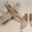

In [7]:
data.train_ds[1][0]

In [ ]:
# show_image_batch(data.train_dl, data.train_ds.classes)

In [8]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

Total time: 04:28
epoch  train loss  valid loss  accuracy
0      1.795702    1.365861    0.535200  (00:20)
1      1.581178    1.207135    0.577200  (00:08)
2      1.440670    1.063459    0.641600  (00:08)
3      1.334411    1.294384    0.584400  (00:08)
4      1.289912    1.274863    0.565400  (00:08)
5      1.241590    0.927619    0.699300  (00:08)
6      1.201504    0.752876    0.767600  (00:08)
7      1.173325    0.698428    0.791800  (00:08)
8      1.162377    0.771245    0.769500  (00:08)
9      1.139921    0.648074    0.817400  (00:08)
10     1.126804    0.617434    0.825300  (00:08)
11     1.117855    0.647468    0.817300  (00:08)
12     1.107589    0.646871    0.801700  (00:08)
13     1.098015    0.714905    0.796200  (00:08)
14     1.087251    0.770405    0.777800  (00:08)
15     1.076816    0.501551    0.870600  (00:08)
16     1.060990    0.556516    0.844400  (00:08)
17     1.043575    0.538492    0.855700  (00:08)
18     1.035051    0.510318    0.875400  (00:08)
19     1.01

In [9]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.bn_wd = False
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

Total time: 04:13
epoch  train loss  valid loss  accuracy
0      1.789306    1.456366    0.468000  (00:08)
1      1.571725    1.181943    0.604300  (00:08)
2      1.428148    0.898890    0.718400  (00:08)
3      1.333608    1.044259    0.660000  (00:08)
4      1.275320    1.186650    0.592100  (00:08)
5      1.228309    0.843180    0.736200  (00:08)
6      1.206232    0.662824    0.803300  (00:08)
7      1.178555    0.763833    0.772100  (00:08)
8      1.159437    0.754386    0.781800  (00:08)
9      1.148030    0.651326    0.810700  (00:08)
10     1.133018    0.883851    0.723200  (00:08)
11     1.125575    0.666752    0.808100  (00:08)
12     1.109944    0.824744    0.751900  (00:08)
13     1.105049    0.620707    0.822100  (00:08)
14     1.094006    0.743840    0.768300  (00:08)
15     1.086294    0.560766    0.852300  (00:08)
16     1.070282    0.493755    0.865100  (00:08)
17     1.045532    0.488506    0.875600  (00:08)
18     1.037327    0.475848    0.881500  (00:08)
19     1.01

In [ ]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.bn_wd = False
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

In [5]:
class fp16cb(Callback):    
    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None: pass
    def on_loss_begin(self, last_output:Tensor, **kwargs:Any) -> Tensor:
        "Convert half precision output to FP32 to avoid reduction overflow."
        return last_output.float()
